# Project 2a: Lexical Semantics and Word Vectors (40 pts)

In [2]:
%%bash

  echo "Downloading files if missing"
  git clone https://github.com/kabirahuja2431/CSE447-547MAutumn2024.git
  cp -r ./CSE447-547MAutumn2024/"Project 2"/data .
  cp ./CSE447-547MAutumn2024/"Project 2"/wordvec_tests.py .
  cp ./CSE447-547MAutumn2024/"Project 2"/nn_tests.py .
  cp ./CSE447-547MAutumn2024/"Project 2"/glove.py .
  cp ./CSE447-547MAutumn2024/"Project 2"/siqa.py .
  wget https://homes.cs.washington.edu/~kahuja/cse447/project2/glove.6B.50d.txt -O data/embeddings/glove.6B/glove.6B.50d.txt


Couldn't find program: 'bash'


Windows Alternative:

In [3]:
# import os
# import subprocess
# import shutil
# 
# # Clone the repository if it doesn't exist
# if not os.path.exists("CSE447-547MAutumn2024"):
#     print("Downloading files if missing")
#     subprocess.run(["git", "clone", "https://github.com/kabirahuja2431/CSE447-547MAutumn2024.git"])
# 
# # Define paths
# source_dir = os.path.join("CSE447-547MAutumn2024", "Project 2")
# dest_dir = "data"
# os.makedirs(dest_dir, exist_ok=True)
# os.makedirs(os.path.join(dest_dir, "embeddings", "glove.6B"), exist_ok=True)
# 
# # Copy necessary files
# shutil.copytree(os.path.join(source_dir, "data"), dest_dir, dirs_exist_ok=True)
# shutil.copy(os.path.join(source_dir, "wordvec_tests.py"), ".")
# shutil.copy(os.path.join(source_dir, "nn_tests.py"), ".")
# shutil.copy(os.path.join(source_dir, "glove.py"), ".")
# shutil.copy(os.path.join(source_dir, "siqa.py"), ".")
# 
# # Download file
# url = "https://homes.cs.washington.edu/~kahuja/cse447/project2/glove.6B.50d.txt"
# output_path = os.path.join(dest_dir, "embeddings", "glove.6B", "glove.6B.50d.txt")
# subprocess.run(["curl", "-o", output_path, url])


In [4]:

# Install required packages
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install sentence-transformers

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
import os
import json
import re
from typing import List, Tuple, Dict, Union
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

from wordvec_tests import (
    load_synonyms_data,
    Exercise1Runner,
    Exercise2Runner,
    Exercise3aRunner,
    Exercise3bRunner,
    Exercise4Runner,
    Exercise5Runner,
    Exercise6Runner
)

C:\Users\Rohan Mukherjee\AppData\Roaming\Python\Python312\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [6]:
parent_dir = os.path.dirname(os.path.abspath("__file__"))
data_dir = os.path.join(parent_dir, "data")

## Part 1: Geometry of Word Embeddings

We provide a helper class to access the glove vectors

In [7]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
class GloveEmbeddings:

    def __init__(self, path="embeddings/glove.6B/glove.6B.50d.txt"):
        self.path = path
        self.vec_size = int(re.search(r"\d+(?=d)", path).group(0))
        self.embeddings = {}
        self.load()

    def load(self):
        for line in open(self.path, "r", encoding="utf-8"):
            values = line.split()

            word_len = len(values) - self.vec_size

            word = " ".join(values[:word_len])
            vector_values = list(map(float, values[word_len:]))

            word = values[0]
            vector_values = list(map(float, values[-self.vec_size:]))
            vector = torch.tensor(vector_values, dtype=torch.float)
            self.embeddings[word] = vector

    def is_word_in_embeddings(self, word):
        return word in self.embeddings

    def get_vector(self, word):
        if not self.is_word_in_embeddings(word):
            return self.embeddings["unk"]
        return self.embeddings[word]

    # Use square operator to get the vector of a word
    def __getitem__(self, word):
        return self.get_vector(word)

In [8]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
glove_vectors = GloveEmbeddings(
    path=f"{data_dir}/embeddings/glove.6B/glove.6B.50d.txt"
)

You can simply use `glove_vectors[<word>]` to get the vector for a word

In [9]:
vector = glove_vectors["the"]
print(vector.shape)
print(vector)

torch.Size([50])
tensor([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])


In [10]:
print(glove_vectors["unk"].shape)
print(glove_vectors["the"].shape)
print(glove_vectors["king"].shape)

torch.Size([50])
torch.Size([50])
torch.Size([50])


Notice that we have a 50 dimensional vector for each word

### Exercise 1: Synonyms (5 pts)

This part is adapted from Dan Jurafsky's NLP class CS124 at Stanford.

In [11]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
dev_synonyms_df = load_synonyms_data("dev", data_dir=data_dir)
dev_synonyms_df.head()

,word,choices,true_answer
0,gullible,"unrealistic,naive,complicated,wary",naive
1,counter,"parry,agree,hold,run",parry
2,feeble,"reinforced,weak,damage,break",weak
3,administer,"give,steal,spray,box",give
4,betray,"trust,inform,table,deceive",deceive


The task is to choose the synonym for a given word from a list of choices. We will use Glove embeddings to find the closest word in the embedding space.

There are different metrics to obtain distance / similarity between two vectors in n-dimensional space. These include:

1. Euclidean Distance: $d(u, v)  = ||u - v||_2$
2. Manhattan Distance: $d(u, v) = ||u - v||_1$
3. Cosine Similarity: $s(u, v) = \frac{u \cdot v}{||u||_2 ||v||_2}$

where $u$ and $v$ are vectors.

You will implement a function `find_synonym` that for a word finds the closest synonym from a list of words. The method also receives a distance / similarity metric to use. The function should return the synonym and the value of the metric for the closest word.


In [12]:
def cosine_similarity(v1: torch.Tensor, v2: torch.Tensor) -> float:
    """
    Compute the cosine similarity between two vectors.

    Inputs:
    v1: torch.Tensor of shape (n,)
    v2: torch.Tensor of shape (n,)

    Returns:
    float: cosine similarity between v1 and v2
    """

    # YOUR CODE HERE
    if torch.norm(v1) == 0 or torch.norm(v2) == 0:
        return 0
    return ((v1 @ v2)/(torch.linalg.vector_norm(v1) * torch.linalg.vector_norm(v2))).item()


def euclidean_distance(v1: torch.Tensor, v2: torch.Tensor) -> float:
    """
    Compute the Euclidean distance between two vectors.

    Inputs:
    v1: torch.Tensor of shape (n,)
    v2: torch.Tensor of shape (n,)

    Returns:
    float: Euclidean distance between v1 and v2
    """
    # YOUR CODE HERE
    return torch.norm(v1-v2, p=2).item()


def manhattan_distance(v1: torch.Tensor, v2: torch.Tensor) -> float:
    """
    Compute the Manhattan distance between two vectors.

    Inputs:
    v1: torch.Tensor of shape (n,)
    v2: torch.Tensor of shape (n,)

    Returns:
    float: Manhattan distance between v1 and v2
    """

    # YOUR CODE HERE
    return torch.norm(v1-v2, p=1).item()


def find_synonym(
    word: str,
    choices: List[str],
    embeddings: GloveEmbeddings,
    metric: str = "cosine"
) -> Dict[str, Union[str, float]]:
    """
    Computes the synonym of `word` using Glove `embeddings`

    Inputs:
    - word: The word for which we want to find the synonym
    - choices: A list of words to choose from
    - embeddings: GloveEmbeddings object
    - metric: The distance metric to use. Can be one of "cosine", "euclidean", or "manhattan"
    """

    synonym_dict = {
        "synonym": None,
        "metric": None
    }

    # YOUR CODE HERE
    if metric == "manhattan":
        similarity = manhattan_distance
    elif metric == "euclidean":
        similarity = euclidean_distance
    else:
        similarity = cosine_similarity
    
    dists = [similarity(embeddings[word], embeddings[choice]) for choice in choices]
    
    if metric == "cosine":
        synonym_dict["synonym"] = choices[np.argmax(dists)]
    else:
        synonym_dict["synonym"] = choices[np.argmin(dists)]
    synonym_dict["metric"] = metric
    
    return synonym_dict
    

In [13]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
exercise1 = Exercise1Runner(
    find_synonym=find_synonym,
)

exercise1.evaluate(True) #Set False if you only want to see the final accuracies

Excercise 1: Synonyms
-----------------
Answering exercise 1 using cosine as the comparison metric...
1. What is a synonym for gullible?
    a) unrealistic
    b) naive
    c) complicated
    d) wary
you answered: naive 

2. What is a synonym for counter?
    a) parry
    b) agree
    c) hold
    d) run
you answered: hold 

3. What is a synonym for feeble?
    a) reinforced
    b) weak
    c) damage
    d) break
you answered: weak 

4. What is a synonym for administer?
    a) give
    b) steal
    c) spray
    d) box
you answered: give 

5. What is a synonym for betray?
    a) trust
    b) inform
    c) table
    d) deceive
you answered: deceive 

6. What is a synonym for scour?
    a) search
    b) allow
    c) gaze
    d) gather
you answered: search 

7. What is a synonym for clean?
    a) bare
    b) tidy
    c) rummage
    d) pop
you answered: bare 

8. What is a synonym for abscond?
    a) escape
    b) rally
    c) relinquish
    d) flash
you answered: relinquish 

9. What is a s

You should expect the dev accuracy to be 83% with cosine similarity metric, 67% with euclidean distance and 70% with manhattan distance.

### Exercise 2: Analogies (3 pts)

In this exercise you will use the Linear Representation Hypothesis (check handout to learn about it) to solve the analogy task:

man is to king as woman is to ______ ?
    a) princess
    b) queen
    c) wife
    d) ruler

The task is to find the most appropriate word out of the 4 choices that completes the analogy.

This part is adapted from Dan Jurafsky's NLP class CS124 at Stanford.

In [14]:
def find_analogy_word(
    a: str,
    b: str,
    aa: str,
    choices: List[str],
    embeddings: GloveEmbeddings,
):

    """
    Given the analogy relation a is to aa as b is to ____, find the word from choices that completes the analogy.
    e.g. man is to king as woman is to ____?
    a) princess
    b) queen
    c) wife
    d) ruler

    Note: Use cosine similarity as the metric for this function.

    Inputs:
    - a, b, aa: The words in the analogy relation
    - choices: A list of words to choose from
    - embeddings: GloveEmbeddings object

    Returns:
     str: The word from choices that best completes the analogy
    """
    
    # idea: bb - b = aa - a => bb = b + (aa-a)
    # b + the thing that turns a into aa.

    # YOUR CODE HERE
    angles = [
        cosine_similarity(embeddings[choice], embeddings[b] + embeddings[aa] - embeddings[a]) 
        for choice in choices
    ]
    answer = choices[np.argmax(angles)]

    return answer


In [15]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
exercise2 = Exercise2Runner(find_analogy_word=find_analogy_word)
exercise2.evaluate(True) #Set False if you only want to see the final accuracies

Excercise 2: Analogies
-----------------
Answering exercise 2...
1. king is to queen as man is to ?
    a) wife
    b) woman
    c) head
    d) ruler
You answered: woman 

2. dog is to puppy as cat is to ?
    a) kitten
    b) puppy
    c) feline
    d) mouse
You answered: puppy 

3. father is to son as mother is to ?
    a) girl
    b) wife
    c) daughter
    d) queen
You answered: daughter 

4. listen is to hear as look is to ?
    a) taste
    b) see
    c) feel
    d) think
You answered: think 

5. doctor is to hospital as lawyer is to ?
    a) court
    b) restaurant
    c) museum
    d) library
You answered: court 

6. good is to great as bad is to ?
    a) better
    b) worse
    c) okay
    d) sad
You answered: worse 

7. stove is to kitchen as tub is to ?
    a) closet
    b) bedroom
    c) bathroom
    d) pantry
You answered: bathroom 

8. spoon is to soup as fork is to ?
    a) sorbet
    b) steak
    c) banana
    d) berry
You answered: steak 

9. phone is to talk as telev

You should see an accuracy of 64%

In [48]:
def test_other_concepts():
    # Relation: Present to past tense
    # go is to went as eat is to ______ ?
    # a) ate
    # b) gone
    # c) going
    # d) eaten
    print(find_analogy_word("go", "went", "eat", ["ate", "gone", "going", "eaten"], glove_vectors))
    
    # Relation: Present to past tense
    # walk is to walked as run is to ______ ?
    # a) ran
    # b) running
    # c) walk
    # d) walks
    print(find_analogy_word("walk", "walked", "run", ["ran", "running", "walk", "walks"], glove_vectors))
    
    # Relation: Sequence order
    # 5 is to 4 as 3 is to ______ ?
    # a) 2
    # b) 1
    # c) 0
    # d) -1

    print(find_analogy_word("5", "4", "3", ["2", "1", "0", "-1"], glove_vectors))    
    
    # Relation: Sequence order
    # one is to two as three is to ______ ?
    # a) four
    # b) five
    # c) six
    # d) seven
    
    print(find_analogy_word("one", "two", "three", ["four", "five", "six", "seven"], glove_vectors))
    
    # Relation: Country Capital
    # France is to Paris as Germany is to ______ ?
    # a) Berlin
    # b) Munich
    # c) Frankfurt
    # d) Hamburg
    
    print(find_analogy_word("France", "Paris", "Germany", ["Berlin", "Munich", "Frankfurt", "Hamburg"], glove_vectors))
    
    # Relation: Country Capital
    # India is to New Delhi as Japan is to ______ ?
    # a) Tokyo
    # b) Kyoto
    # c) Osaka
    # d) Hiroshima
    print(find_analogy_word("India", "New Delhi", "Japan", ["Tokyo", "Kyoto", "Osaka", "Hiroshima"], glove_vectors))

test_other_concepts()

ate
ran
2
four
Berlin
Tokyo


### Exercise 3: Bias in Word Embeddings (10 pts)

We will now implement the Word Embedding Association Test (WEAT) to identify biases in word embeddings. Check the handout for a detailed explanation of the test. You will start by implementing the *Effect Size* metric by implementing the functions:

- `word_association_wth_attribute`
- `weat_effect_size`

`word_association_wth_attribute` computes $s(w, A, B)$ for a given word $w$ and attributes $A$ and $B$, i.e. the association of the word with the attributes. Recall that this is given by:

$$s(w, A, B) = \text{mean}_{a \in A}\text{cos}(\vec{w}, \vec{a}) - \text{mean}_{b \in B} (\vec{w}, \vec{b})$$

The effect size is then given as:

$$\text{effect-size} = \frac{\text{mean}_{x \in X} s(x, A, B) - \text{mean}_{y \in Y} s(y, A, B)}{\text{std-dev}_{w \in X \cup Y} s(w, A, B)}$$

In [17]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
with open(f"{data_dir}/weat/weat.json", "r") as f:
    weat_data = json.load(f)

weat_data.keys()

dict_keys(['Careers_Female_Male', 'EuropeanAmerican_AfricanAmerican_Pleasant_Unpleasant', 'EuropeanAmerican_AfricanAmerican_Pleasant_Unpleasant_2', 'Flowers_Insects_Pleasant_Unpleasant', 'Male_Female_Career_Family', 'Math_Arts_Male_Female', 'MusicalInstruments_Weapons_Pleasant_Unpleasant', 'Names_Female_Male', 'Science_Arts_Male_Female'])

In [18]:
def word_association_wth_attribute(
    word: str,
    A: List[str],
    B: List[str],
    embeddings: GloveEmbeddings,
) -> float:

    """
    Finds the association of a word in the emedding space with the two sets of attribute words.
    E.g. Given the word "rose", a set of pleasant words A and unpleasant words B, the function finds if its degree of association to A vs B.

    Inputs:
    - word: The word for which we want to find the association
    - A: List of words representing the first set of attributes
    - B: List of words representing the second set of attributes

    Returns:
    float: The association of the word with the two sets of attributes
    """

    return np.mean([cosine_similarity(embeddings[word], embeddings[a]) for a in A]) - np.mean([cosine_similarity(embeddings[word], embeddings[b]) for b in B])

def weat_effect_size(
    X: List[str],
    Y: List[str],
    A: List[str],
    B: List[str],
    embeddings: GloveEmbeddings,
) -> float:
    """
    Compute the effect size of the WEAT test.

    Inputs:
    - X: List of target words for which we want to find the association.
    - Y: List of target words for which we want to find the association.
    - A: List of words representing the first set of attributes
    - B: List of words representing the second set of attributes
    - embeddings: GloveEmbeddings object
    """
    effect_size = ((np.mean([word_association_wth_attribute(x, A, B, embeddings) for x in X]) - np.mean([word_association_wth_attribute(y, A, B, embeddings) for y in Y])) / 
                   np.std([word_association_wth_attribute(w, A, B, embeddings) for w in X + Y]))

    return effect_size

In [19]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
exercise3 = Exercise3aRunner(
    weat_effect_size=weat_effect_size,
)
exercise3.evaluate_effect_size(
    False
)  # Set False if you only want to see the final effect sizes

Excercise 3a: WEAT Effect Size
-----------------
Effect size for Flowers-Insects Pleasant Unpleasant case: 1.08876
Effect size for MusicalInstruments-Weapons Pleasant Unpleasant case: 1.55964
Effect size for EuropeanAmerican AfricanAmerican_Pleasant_Unpleasant case: 1.00901
Effect size for Male_Female Career_Family case : 1.76379
Effect size for Math_Art Male_Female case : 1.54417


You should observe the following numbers:


Effect size for Flowers-Insects Pleasant Unpleasant case: 1.07782

Effect size for MusicalInstruments-Weapons Pleasant Unpleasant case: 1.54396

Effect size for EuropeanAmerican AfricanAmerican_Pleasant_Unpleasant case: 1.00395

Effect size for Male_Female Career_Family case : 1.70778

Effect size for Math_Art Male_Female case : 1.49513

We will now check how statistically significant are these effect sizes. You will implement the function `target_words_diff_association_wth_attribute` which calculates the value of the test statistic: $s(X, Y, A, B)$. Recall this is given by:

$$    s(X, Y, A, B) = \sum_{x \in X} s(x, A, B) - \sum_{y \in Y} s(y, A, B)$$

We then use this function to calculate the p-value of the permutation test. We provide you the implementation of the function `weat_p_value`. We recommend you to go through the code to understand how the p-value is calculated, even though you are not supposed to implement it.

In [20]:
def target_words_diff_association_wth_attribute(
    X: List[str],
    Y: List[str],
    A: List[str],
    B: List[str],
    embeddings: GloveEmbeddings,
) -> float:
    """
    Finds the differential association of words in X with the attribute sets A and B vs the words in Y with the attribute sets A and B.

    E.g. X can be flower names and Y can be insect names.A can be pleasant words and B can be unpleasant words.
    The function measures the difference in total association of flower names and insect names with sets A and B.


    Inputs:
    - words: List of target words for which we want to find the association.
    - A: List of words representing the first set of attributes
    - B: List of words representing the second set of attributes
    - embeddings: GloveEmbeddings object
    """

    return np.sum([word_association_wth_attribute(x, A, B, embeddings) for x in X]) - np.sum([word_association_wth_attribute(y, A, B, embeddings) for y in Y])


######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
def weat_p_value(
    X: List[str],
    Y: List[str],
    A: List[str],
    B: List[str],
    embeddings: GloveEmbeddings,
    max_permutations: int = 1000,
) -> Tuple[float, float]:
    """
    Compute the p-values of the WEAT test.

    Inputs:
    - X: List of target words for which we want to find the association.
    - Y: List of target words for which we want to find the association.
    - A: List of words representing the first set of attributes
    - B: List of words representing the second set of attributes
    - embeddings: GloveEmbeddings object
    """

    import numpy as np
    diff_association = target_words_diff_association_wth_attribute(X, Y, A, B, embeddings)

    target_words = X + Y
    # print(len(target_words))

    partition_idx = np.zeros(len(target_words))
    partition_idx[:len(target_words) // 2] = 1

    partition_dff_associations = []
    for _ in range(max_permutations):
        if len(partition_dff_associations) >= max_permutations:
            break
        i = np.random.permutation(partition_idx)
        X_perm = [target_words[j] for j in range(len(target_words)) if i[j] == 1]
        Y_perm = [target_words[j] for j in range(len(target_words)) if i[j] == 0]
        partition_dff_associations.append(
            target_words_diff_association_wth_attribute(
                X_perm, Y_perm, A, B, embeddings
            )
        )
    return np.sum(np.array(partition_dff_associations) > diff_association) / len(
        partition_dff_associations
    )

In [21]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
exercise3b = Exercise3bRunner(
    weat_p_value=weat_p_value,
)

exercise3b.evaluate(True) #Set False if you only want to see the final p-values # This might take a while to run (1 minute during our testing)

Excercise 3b: WEAT P-Value
-----------------
Answering exercise 3 using EuropeanAmerican_AfricanAmerican_Pleasant_Unpleasant as the dataset...
Target Group X: ['adam', 'chip', 'harry', 'josh', 'roger', 'alan', 'frank', 'ian', 'justin', 'ryan', 'andrew', 'fred', 'jack', 'matthew', 'stephen', 'brad', 'greg', 'jed', 'paul', 'todd', 'brandon', 'hank', 'jonathan', 'peter', 'wilbur', 'amanda', 'courtney', 'heather', 'melanie', 'sara', 'amber', 'crystal', 'katie', 'meredith', 'shannon', 'betsy', 'donna', 'kristin', 'nancy', 'stephanie', 'bobbie-sue', 'ellen', 'lauren', 'peggy', 'sue-ellen', 'colleen', 'emily', 'megan', 'rachel', 'wendy']
Target Group Y: ['alonzo', 'jamel', 'lerone', 'percell', 'theo', 'alphonse', 'jerome', 'leroy', 'rasaan', 'torrance', 'darnell', 'lamar', 'lionel', 'rashaun', 'tvree', 'deion', 'lamont', 'malik', 'terrence', 'tyrone', 'everol', 'lavon', 'marcellus', 'terryl', 'wardell', 'aiesha', 'lashelle', 'nichelle', 'shereen', 'temeka', 'ebony', 'latisha', 'shaniqua', 'ta

You should see p-values as 0.0 for all the cases (Note that this is approximate since we are not exaustively considering all the permutations and only considering 1000 random permutations. But the actual p-value should be very close to 0.)

### Useful pointers for write up question 3 in 1.1.3 of handout:

Glove embeddings of size {{vec_dim}} (e.g. 50) trained on {{num_tokens}} (e.g. 6B) can be loaded as:

```
glove_vectors = load_glove_vectors(
    f"{data_dir}/embeddings/glove.6B/glove.WEAT.6B.50d.txt",
)
```

where you change the values of 6B and 50 based on the size of the embeddings and number of tokens used in training.

To load weat data of a particular category, you can use the following code:

```
category = "Flowers_Insects_Pleasant_Unpleasant" # Change this to the category you want to load

weat_category_data = weat_data[category]

X = weat_category_data["X"]
Y = weat_category_data["Y"]
A = weat_category_data["A"]
B = weat_category_data["B"]
```

In [22]:
# Effect of scale on WEAT Effect Sizes

names = ["EuropeanAmerican_AfricanAmerican_Pleasant_Unpleasant", "Flowers_Insects_Pleasant_Unpleasant", "Male_Female_Career_Family", "Math_Arts_Male_Female", "MusicalInstruments_Weapons_Pleasant_Unpleasant"]

def get_weat_effect_size(weat_data, glove_embeddings):
    X, Y, A, B = weat_data[weat_data["X_key"]], weat_data[weat_data["Y_key"]], weat_data[weat_data["A_key"]], weat_data[weat_data["B_key"]]

    effect_size = weat_effect_size(X, Y, A, B, glove_embeddings)
    return effect_size

def get_effect_sizes_6b_tokens():
    vector_sizes = [50, 100, 200, 300]
    effect_sizes_6b_tokens = [[] for _ in names]
    
    for vector_size in vector_sizes:
        glove_embeddings = GloveEmbeddings(
            path=f"{data_dir}/embeddings/glove.6B/glove.WEAT.6B.{vector_size}d.txt"
        )
        
        for i, name in enumerate(names):
            data = weat_data[name]
            effect_sizes_6b_tokens[i].append(get_weat_effect_size(data, glove_embeddings))
            
    plt.figure()
    
    for name, data in zip(names, effect_sizes_6b_tokens):
        plt.plot(vector_sizes, data, label=name)
        
    plt.title("Effect sizes vs vector size for 6B tokens")
    plt.xlabel("Vector size")
    plt.ylabel("Effect size")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

def get_effect_sizes_300d_vectors():
    num_tokens = ["6B", "42B", "840B"]
    effect_sizes_300d_vectors = [[] for _ in names]
    
    for num_token in num_tokens:
        glove_embeddings = GloveEmbeddings(
            path=f"{data_dir}/embeddings/glove.{num_token}/glove.WEAT.{num_token}.300d.txt"
        )
        
        for i, name in enumerate(names):
            data = weat_data[name]
            effect_sizes_300d_vectors[i].append(get_weat_effect_size(data, glove_embeddings))
        
    plt.figure()
    
    for name, data in zip(names, effect_sizes_300d_vectors):
        plt.plot(num_tokens, data, label=name)
        
    plt.title("Effect sizes vs num tokens for 300d vectors")
    plt.xlabel("Number of tokens (billions)")
    plt.ylabel("Effect size")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

# get_effect_sizes_6b_tokens()
# get_effect_sizes_300d_vectors()

## Part 2: From Word Embeddings to Sentence Level Embeddings

### Exercise 3.1 Sentence Similarity (3 pts)

*This part is adapted from Dan Jurafsky's NLP class CS124 at Stanford.*

In this exercise you will be building sentence level representations using word embeddings and then use them to find similarity between two sentences. In particular your goal is to answer questions of the form:

```
    True/False: the following two sentences are semantically similar:
      1. he later learned that the incident was caused by the concorde's sonic boom
      2. he later found out the alarming incident had been caused by concorde's powerful sonic boom
```

To build sentence level representations, you will use the following approaches:

* **Simple sum**: Simply take the sum of word embeddings of all words in the sentence
* **Sum with POS weighting**: Take a weighted sum of the individual word vectors, where the weight of each word depends on the part of speech tag (POS) of the word.

Specifically, you will implement the following functions:
* **get_sentence_embedding()**: given a sentence (string), return the sentence embedding (vector). The function also takes in the parameter `use_POS`:
    * if `use_POS` is false (regular case), leverage method 1 above - simply the sum of the word embeddings for each word in the sentence (ignoring words that don’t appear in our vocabulary).
    * if `use_POS` is true, leverage method 2 - use a weighted sum, where we weight each word by a scalar that depends on its part of speech tag.
* **get_sentence_similarity()**: given two sentences, find the cosine similarity between their corresponding sentence embeddings.

Helpful hints:

* Lowercase all words in the sentence before you look them up in the embeddings. The Glove embeddings that we are using have all words in lowercase.

* We’ve given you a map `POS_weights` that maps part of speech tags to their associated weight. For example, `POS_weights['NN'] = 0.8` (where NN is the POS tag for noun).
* You may skip words that either (1) are not in our embeddings or (2) have a POS tag that is not in `POS_weights` . To check if a word is not in our embeddings, you can use the following code snippet:

```
    if glove_vectors.is_word_in_embeddings(word):
        # word is in embeddings
    else:
        # word is not in embeddings
```
* To get a list of all the words in the sentence, use nltk's word_tokenize function.

  ```
  >>> sentence = "this is a sentence"
  >>> word_tokens = word_tokenize(sentence)
  >>> word_tokens
  ['this', 'is', 'a', 'sentence']
  ```
  
  * To get the POS tags for each word in a sentence, you can use nltk.pos_tag. To use it, you provide a list of words in a sentence, and it returns a list of tuples, where the first element is the word and the second is its corresponding POS tag. **For this PA, make sure that you pass in the entire sentence to a single call to nltk.pos_tag; do not call  nltk.pos_tag separately on each word in the sentence.** This is because some words can be multiple parts of speech (for example, "back" can be a noun or a verb). Passing in the entire sentence allows for more context to figure out what POS tag a word should have.

```
    >>> tagged_words = nltk.pos_tag(word_tokens)
    >>> tagged_words
    [('this', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('sentence', 'NN')]`
```



In [23]:
# You will use nltk for tokenizing and tagging!
import nltk

In [24]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
# Run this cell to download the nltk tagger
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download("averaged_perceptron_tagger_eng")

[nltk_data] Downloading package punkt to C:\Users\Rohan
[nltk_data]     Mukherjee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Rohan Mukherjee\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Rohan Mukherjee\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [25]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
# Run this cell to load POS Weights
with open(f"{data_dir}/pos_weights.txt", "r") as f:
    pos_weights = f.read().split("\n")
    pos_weights = {line.split()[0]: float(line.split()[1]) for line in pos_weights}
print(pos_weights)

{'CC': 0.7, 'CD': 0.8, 'DT': 0.7, 'EX': 0.7, 'FW': 0.7, 'IN': 0.7, 'JJ': 0.7, 'JJR': 0.7, 'JJS': 0.8, 'LS': 0.7, 'MD': 1.2, 'NN': 0.8, 'NNS': 1.0, 'NNP': 0.8, 'NNPS': 0.8, 'PDT': 0.7, 'POS': 0.7, 'PRP': 0.7, 'PRP$': 0.7, 'RB': 1.3, 'RBR': 1.2, 'RBS': 1.0, 'RP': 1.2, 'SYM': 0.7, 'TO': 0.8, 'UH': 0.7, 'VB': 1.2, 'VBD': 1.2, 'VBG': 1.1, 'VBN': 0.8, 'VBP': 1.2, 'VBZ': 1.2, 'WDT': 0.7, 'WP': 0.7, 'WP$': 0.7, 'WRB': 1.3}


In [26]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
# Run this cell to load the dataset
sentence_df = pd.read_csv(f"{data_dir}/sentence_similarity/dev.csv", sep="\t", header=None, names=["label", "sentence1", "sentence2"])
sentence_df.head()

,label,sentence1,sentence2
0,1,one woman is measuring another woman's ankle.,a woman measures another woman's ankle.
1,1,a man is cutting an onion.,a man cuts an onion.
2,1,a young woman is putting stickers all over her...,a woman is applying stickers to her face.
3,1,a woman is dancing in the rain.,a woman dances in the rain out side.
4,1,the man is kissing and hugging the woman.,a man is hugging and kissing a woman.


In [29]:
def get_sentence_embedding(
    sentence: str,
    word_embeddings: GloveEmbeddings,
    use_POS: bool = False,
    pos_weights: Dict[str, float] = None,
):
    """
    Compute the sentence embedding using the word embeddings.

    Inputs:
    - sentence: The input sentence
    - word_embeddings: GloveEmbeddings object
    - use_POS: Whether to use POS tagging
    - pos_weights: Dictionary containing POS weights

    Returns:
    torch.Tensor: The sentence embedding
    """

    sentence_embedding = torch.zeros(word_embeddings['the'].shape)
    # not sure why this changes accuracy...
    if use_POS:
        for word, tag in nltk.pos_tag(nltk.word_tokenize(sentence.lower())):
            if word_embeddings.is_word_in_embeddings(word) and tag in pos_weights:
                weight = pos_weights[tag] if use_POS else 1
                sentence_embedding += weight * word_embeddings[word]
    else:
        for word in nltk.word_tokenize(sentence.lower()):
            if word_embeddings.is_word_in_embeddings(word):
                sentence_embedding += word_embeddings[word]
    return sentence_embedding


def get_sentence_similarity(
    sentence1: str,
    sentence2: str,
    word_embeddings: GloveEmbeddings,
    use_POS: bool = False,
    pos_weights: Dict[str, float] = None,
):
    """
    Compute the similarity between two sentences.

    Inputs:
    - sentence1: The first input sentence
    - sentence2: The second input sentence
    - word_embeddings: GloveEmbeddings object
    - use_POS: Whether to use POS tagging
    - pos_weights: Dictionary containing POS weights

    Returns:
    float: The similarity between the two sentences
    """

    return cosine_similarity(get_sentence_embedding(sentence1, word_embeddings, use_POS, pos_weights), get_sentence_embedding(sentence2, word_embeddings, use_POS, pos_weights))

In [30]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
exercise4 = Exercise4Runner(
    get_sentence_similarity=get_sentence_similarity,
)

exercise4.evaluate(True) #Set False if you only want to see the final accuracies

Excercise 4: Sentence Similarity
-----------------
Answering exercise 4...
1. Are the following sentences similar?
    Sentence 1: one woman is measuring another woman's ankle.
    Sentence 2: a woman measures another woman's ankle.
 You answered: Cosine Similarity = 0.98057, Prediction = 1
 
2. Are the following sentences similar?
    Sentence 1: a man is cutting an onion.
    Sentence 2: a man cuts an onion.
 You answered: Cosine Similarity = 0.99188, Prediction = 1
 
3. Are the following sentences similar?
    Sentence 1: a young woman is putting stickers all over her face.
    Sentence 2: a woman is applying stickers to her face.
 You answered: Cosine Similarity = 0.98327, Prediction = 1
 
4. Are the following sentences similar?
    Sentence 1: a woman is dancing in the rain.
    Sentence 2: a woman dances in the rain out side.
 You answered: Cosine Similarity = 0.98769, Prediction = 1
 
5. Are the following sentences similar?
    Sentence 1: the man is kissing and hugging the woma

Note that our tester is using a threshold of 0.95 for the similarity score, i.e. we consider the prediction as 1 if cosine similarity return by your function is greater than 0.95, else consider it as 0. You should expect the following accuracies:

accuracy using sum of word vectors : 0.85

accuracy using sum of word vectors with POS weights : 0.925

### Exercise 5. K-Nearest Neighbors Classifier using Glove-Based Sentence Embeddings (4 pts)

We will now utilize the sentence representations to build a K-Nearest Neighbors (KNN) classifier. A KNN classifier classifies a sentence by finding its nearest neighbors (in the embedding space) in the training data and taking a majority vote of the labels of neighbors.


 We will be working with the STS dataset from HW1, i.e. classifying the sentiment of movie reviews (we will consider both binary and 5-class classification case). You will implement the following class:

`GloveKNNClassifier` with methods:
- `__init__`: Initialize the classifier with the value of k and the choice of sentence embedding method (simple sum or sum with POS weights)
- `fit`: Calculates the sentence embeddings for all sentences in the training data and stores them. Also stores the corresponding labels.
- `predict`: Predicts the label(s) for the given sentence(s) using the K-Nearest Neighbors algorithm. The distance metric to use is cosine similarity.

Helpful Tips:

- Lower case the training as well as test sentences before computing their embeddings (if your `get_sentence_embedding` already handles that for you, you don't need to do it again here)

- To avoid division by zero when calculating cosine similarity, you can add a small epsilon value i.e. 1e-8 to the denominator.

- We strongly recommend implementing a vectorized version of `cosine_similarity` here, i.e. instead of one by one computing similarity between a test sentence and a training sentence, implement a function which takes n test sentences and m train sentences and uses matrix multiplication operations to get a similarity matrix of shape [n, m]

In [35]:
class GloveKNNClassifier:

    def __init__(self, word_embeddings: GloveEmbeddings, k: int = 5, use_POS: bool = False, pos_weights: Dict[str, float] = None):
        """
        Initialize the KNN Classifier.
        Inputs:
        - word_embeddings: GloveEmbeddings object
        - k: Number of nearest neighbors to consider
        - use_POS: Whether to use POS tag based weights for the embeddings
        - pos_weights: Dictionary containing POS weights

        """

        # YOUR CODE HERE
        self.word_embeddings = word_embeddings
        self.k = k
        self.use_POS = use_POS
        self.pos_weights = pos_weights
        self.X = torch.Tensor
        self.y = torch.Tensor

    def fit(self, X_train: List[str], y_train: List[int]):
        """
        Fit the KNN Classifier by calculating the sentence embeddings for the training sentences and storing them. Also store the corresponding labels.
        Inputs:
        - X_train: List of training sentences (documents)
        - y_train: List of corresponding labels
        """

        # YOUR CODE HERE
        self.X = torch.stack([get_sentence_embedding(sentence, self.word_embeddings, self.use_POS, self.pos_weights) for sentence in X_train])
        self.y = torch.tensor(y_train)

    def predict(self, X_test: List[str]) -> List[int]:
        """
        Predicts the labels for the test sentences using the training data embeddings.

        Inputs:
        - X_test: List of test sentences

        Returns:
        - List of predicted labels

        Hint: `torch.topk` might be useful here.
        """

        closest_k = torch.topk(
            self.cosine_similarity_vectorized(
                torch.stack(
                    [get_sentence_embedding(sentence, self.word_embeddings, self.use_POS, self.pos_weights) for sentence in X_test]
                ), self.X), 
            self.k, dim=1)
        labels = self.y[closest_k.indices]
        
        # YOUR CODE HERE
        return labels.mode().values.tolist()

    # Any extra functions you need can be added here
    # YOUR CODE HERE
    def cosine_similarity_vectorized(self, v1: torch.Tensor, v2: torch.Tensor) -> torch.Tensor:
        """
        Compute the cosine similarity between two vectors.

        Inputs:
        v1: torch.Tensor of shape (n,k)
        v2: torch.Tensor of shape (m,k)

        Returns:
        torch.Tensor: cosine similarity between v1 and v2
        """

        # YOUR CODE HERE
        return (v1 @ v2.T 
                / 
                (torch.linalg.vector_norm(v1, dim=1).unsqueeze(1) * torch.linalg.vector_norm(v2, dim=1).unsqueeze(0) + 1e-8))

In [36]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################

exercise5 = Exercise5Runner(GloveKNNClassifier)
exercise5.evaluate(k=5)

Excercise 5: KNN Classifier
-----------------
Binary Classification using k = 5 using sum of word vectors
Accuracy on train set: 0.76884
Accuracy on dev set: 0.65849
 
Multiclass Classification using k = 5 using sum of word vectors
Accuracy on train set: 0.52037
Accuracy on dev set: 0.30609
 
Binary Classification using k = 5 using sum of word vectors with POS weights
Accuracy on train set: 0.77259
Accuracy on dev set: 0.63306
 
Multiclass Classification using k = 5 using sum of word vectors with POS weights
Accuracy on train set: 0.52224
Accuracy on dev set: 0.27702


You should see the following accuracies:

Binary Classification:
- Train accuracy using sum of word vectors : 0.76884
- Dev accuracy using sum of word vectors with POS weights : 0.65849

- Train accuracy using sum of word vectors with POS weights : 0.77142
- Dev accuracy using sum of word vectors with POS weights : 0.63397

Multi-class Classification:
- Train accuracy using sum of word vectors : 0.52037
- Dev accuracy using sum of word vectors with POS weights : 0.30609

- Train accuracy using sum of word vectors with POS weights : 0.52095
- Dev accuracy using sum of word vectors with POS weights : 0.27611

A good way to debug your code can be to check if you get 100% train accuracies for all the cases when you use `k = 1`, since the closest point to a point is the point itself. You can check that by running:

```
exercise5.evaluate(k=1)
```

Excercise 5: KNN Classifier
-----------------
Binary Classification using k = 1 using sum of word vectors
Accuracy on train set: 0.99941
Accuracy on dev set: 0.61580
 
Multiclass Classification using k = 1 using sum of word vectors
Accuracy on train set: 0.99941
Accuracy on dev set: 0.29519
 
Binary Classification using k = 1 using sum of word vectors with POS weights
Accuracy on train set: 0.99941
Accuracy on dev set: 0.62489
 
Multiclass Classification using k = 1 using sum of word vectors with POS weights
Accuracy on train set: 0.99941
Accuracy on dev set: 0.29700
Excercise 5: KNN Classifier
-----------------
Binary Classification using k = 3 using sum of word vectors
Accuracy on train set: 0.81437
Accuracy on dev set: 0.64941
 
Multiclass Classification using k = 3 using sum of word vectors
Accuracy on train set: 0.57877
Accuracy on dev set: 0.27793
 
Binary Classification using k = 3 using sum of word vectors with POS weights
Accuracy on train set: 0.81156
Accuracy on dev set: 0.6

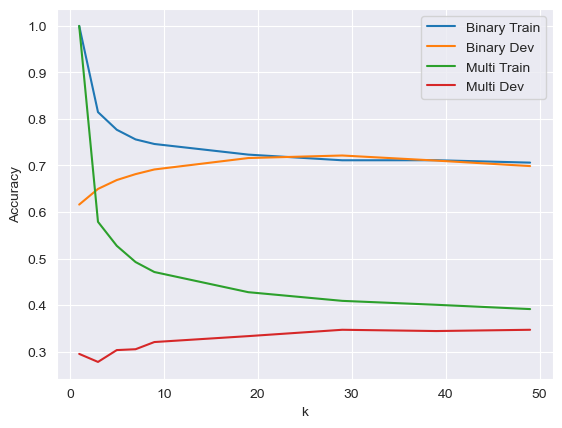

In [63]:
# effect of k on KNN Classifier Performance
def get_effect_of_k_on_knn_performance():
    ks = [1, 3, 5, 7, 9, 19, 29, 39, 49]
    
    binary_train_accs = []
    binary_dev_accs = []
    multi_train_accs = []
    multi_dev_accs = []
    for k in ks:
        accs = exercise5.evaluate(k=k, return_vals=True)
        binary_train_accs.append(accs['binary']['sum']['train'])
        binary_dev_accs.append(accs['binary']['sum']['dev'])
        multi_train_accs.append(accs['multiclass']['sum']['train'])
        multi_dev_accs.append(accs['multiclass']['sum']['dev'])

    # plot the accuracies
    plt.figure()
    plt.plot(ks, binary_train_accs, label="Binary Train")
    plt.plot(ks, binary_dev_accs, label="Binary Dev")
    plt.plot(ks, multi_train_accs, label="Multi Train")
    plt.plot(ks, multi_dev_accs, label="Multi Dev")
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

# get_effect_of_k_on_knn_performance()

You must have noticed that the nearest neighbor classifier with glove embeddings doesn't perform very good, in fact it performs worse than the the linear classifiers we trained in HW1. One of the reasons why this happens is because the way we construct the sentence embeddings by summing the word embeddings? Can you think of the issues with such approach?

### Exercise 6:  K-Nearest Neighbors Classifier using Transformer Based Sentence Embeddings (3 pts)

We will now utilize pre-trained transformers based sentence embeddings to build our KNN classifier. These embeddings are trained a large text corpora and learn sentence level representations which are much more powerful than the simple sum of word embeddings.
While we haven't covered transformers based sentence embeddings in the class yet, we would like to give you a flavour of how the directly trained sentence level representations can be more powerful. We will be using the `sentence-transformers` library to get the sentence embeddings. Below we provide you with a helper function `get_st_embeddings` which takes in a list of sentences, and a sentence transformers model, and returns the sentence embeddings using the `sentence-transformers` library.

In [28]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
from sentence_transformers import SentenceTransformer

def get_st_embeddings(
    sentences: List[str],
    st_model: SentenceTransformer,
    batch_size: int = 32,
    device: str = "cpu",
):
    """
    Compute the sentence embedding using the Sentence Transformer model.

    Inputs:
    - sentence: The input sentence
    - st_model: SentenceTransformer model
    - batch_size: Encode in batches to avoid memory issues in case multiple sentences are passed

    Returns:
    torch.Tensor: The sentence embedding of shape [d,] (when only 1 sentence) or [n, d] where n is the number of sentences and d is the embedding dimension
    """

    st_model.to(device)
    sentence_embeddings = None

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i : i + batch_size]
        batch_embeddings = st_model.encode(batch_sentences, convert_to_tensor=True)
        if sentence_embeddings is None:
            sentence_embeddings = batch_embeddings
        else:
            sentence_embeddings = torch.cat(
                [sentence_embeddings, batch_embeddings], dim=0
            )

    return sentence_embeddings.to("cpu")

In [29]:
# Example usage

# Load model
st_model = SentenceTransformer(
    "all-mpnet-base-v2"
)  # You can use any model from the Sentence Transformers library. See the list here: https://sbert.net/docs/sentence_transformer/pretrained_models.html

# Get embeddings
sent_embeddings = get_st_embeddings(
    ["This is a test sentence", "This is another test sentence"], st_model
)
print(sent_embeddings.shape)

torch.Size([2, 768])


In [32]:
class SentenceTransformerKNNClassifier(GloveKNNClassifier):

    def __init__(
        self, st_model: str = "all-mpnet-base-v2", k: int = 5, batch_size: int = 128
    ):

        super().__init__(None, k)

        self.st_model = SentenceTransformer(st_model)
        self.k = k
        self.batch_size = batch_size

    def fit(self, X_train: List[str], y_train: List[int]):

        # YOUR CODE HERE
        self.X = get_st_embeddings(X_train, self.st_model, self.batch_size)
        self.y = torch.tensor(y_train)

    def predict(self, X_test: List[str]) -> List[int]:

        # YOUR CODE HERE
        closest_k = torch.topk(
            self.cosine_similarity_vectorized(
                get_st_embeddings(X_test, self.st_model, self.batch_size), self.X), 
            self.k, dim=1)
        labels = self.y[closest_k.indices]
        
        # YOUR CODE HERE
        return labels.mode().values.tolist()

    # Any extra functions you need can be added here
    # YOUR CODE HERE
    def cosine_similarity_vectorized(self, v1: torch.Tensor, v2: torch.Tensor) -> torch.Tensor:
        """
        Compute the cosine similarity between two vectors.

        Inputs:
        v1: torch.Tensor of shape (n,k)
        v2: torch.Tensor of shape (m,k)

        Returns:
        torch.Tensor: cosine similarity between v1 and v2
        """

        # YOUR CODE HERE
        return (v1 @ v2.T 
                / 
                (torch.norm(v1, dim=1).unsqueeze(1) * torch.norm(v2, dim=1).unsqueeze(0) + 1e-8))

In [33]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
# You can first evaluate your implementation on debug mode that only uses a fraction of train and dev sets
exercise6 = Exercise6Runner(SentenceTransformerKNNClassifier)
exercise6.evaluate(k=10, debug=True)

Excercise 6: Sentence Transformer KNN Classifier
-----------------
Running on Debug Model. Will only use 100 examples in training and 10 examples for dev set
 
Binary Classification using k = 10 using Sentence Transformer
Accuracy on dev set: 0.90000
 
Multiclass Classification using k = 10 using Sentence Transformer
Accuracy on dev set: 0.30000


In the debug model you should see a dev accuracy of 0.9 for binary case and 0.3 for multi-class case. Note that these are not the actual accuracy values, but a way to check if your code is running without any errors. Once you are satisfied with the debug accuracies, you can run the code below to get the actual accuracies.

In [34]:
######################################################
#  The following code is given to you. DO NOT MODIFY.
######################################################
# This will take a while to run (can take upto 40 minutes).
# You can reduce the runtime by using a GPU runtime and using device="cuda" while calling `get_st_embeddings` function.

exercise6 = Exercise6Runner(SentenceTransformerKNNClassifier)
exercise6.evaluate(k=10, debug=False)

Excercise 6: Sentence Transformer KNN Classifier
-----------------
Binary Classification using k = 10 using Sentence Transformer
Accuracy on dev set: 0.81471
 
Multiclass Classification using k = 10 using Sentence Transformer
Accuracy on dev set: 0.42507


You should see the following accuracies:

Binary Classification:
- Dev accuracy: 0.81471

Multi-class Classification:
- Dev accuracy: 0.42507

As you can see we get much better numbers than the glove embeddings (a 10% improvement). We can further improve these numbers by fine-tuning the transformer model on our specific task, but that is out of the scope of this assignment.